# Check Convergence Settings
Plot the convergence wrt cutoff choices.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from ase.db import connect
import pandas as pd
import numpy as np

## Load in the Data
Group by structure and different settings

In [2]:
data = []
with connect('convergence.db') as db:
    for row in db.select(''):
        atoms = row.toatoms()
        data.append({
            'composition': atoms.get_chemical_formula(),
            'energy': atoms.get_potential_energy(),
            'forces': atoms.get_forces(),
            'n_atoms': len(atoms),
            **row.key_value_pairs
        })
data = pd.DataFrame(data)

## Plot Energy and Force Diff wrt Cutoff
Hold the relative cutoff constant and run

In [3]:
rel_cutoff_fixed: float = 50

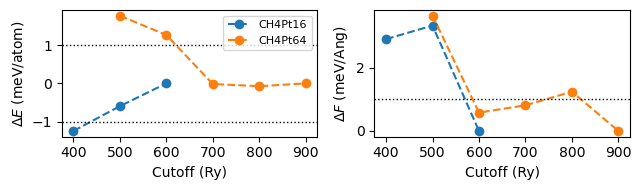

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(6.5, 2.), sharex=True)
for (comp, xc, basis), group in data.query(f'rel_cutoff=={rel_cutoff_fixed}').groupby(['composition', 'xc', 'basis_set']):
    group = group.sort_values('cutoff')
    n_atoms = group.iloc[0]['n_atoms']
    label = f'{comp}'
    
    # Plot the energy and force diffs
    cutoffs = group['cutoff']
    energy_diffs = group['energy'] - group['energy'].iloc[-1]
    force_diffs = group['forces'].apply(lambda x: np.subtract(x, group['forces'].iloc[-1])).apply(np.abs).apply(np.max)
    
    axs[0].plot(cutoffs, energy_diffs * 1000, '--o', label=label)
    axs[1].plot(cutoffs, force_diffs * 1000, '--o', label=label)
    
# Place the convergence levels
for ax in axs:
    ax.set_xlim(ax.get_xlim())
eng_conv = 1  # meV/Ang
for i in [-1, 1]:
    axs[0].plot(axs[0].get_xlim(), [eng_conv * i] * 2, 'k:', lw=1)
    
force_conv = 1  # meV/Ang
axs[1].plot(axs[1].get_xlim(), [force_conv] * 2, 'k:', lw=1)


# Make the labels
axs[0].legend(fontsize=8)
axs[0].set_ylabel('$\Delta E$ (meV/atom)')
axs[1].set_ylabel('$\Delta F$ (meV/Ang)')
for ax in axs:
    ax.set_xlabel('Cutoff (Ry)')

fig.tight_layout()

Seems like a cutoff of 7 should be sufficient based on force and energy.